In [1]:
# Data-handling imports
import pandas as pd
import numpy as np
import eda

# Text-handling imports
import spacy

# Other imports
from progress import show_progress
import matplotlib.pyplot as plt

# Options
freq_col = "freq_per_100000"

# Read in data

## Essays

In [2]:
# Read in essay and score data
essays = pd.read_csv("../data_private/train.tsv", sep="\t")

## NLP data

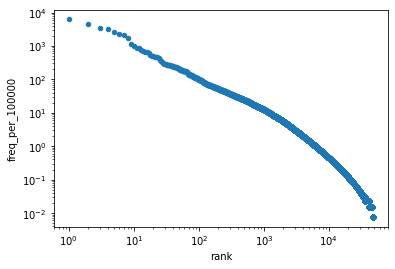

In [3]:
# Read in American English word frequency list
freqs = pd.read_csv("../data/anc_frequency_list.csv")

# Merge homonyms, as they won't affect the analysis much
freqs = pd.DataFrame(freqs.groupby("lemma")[freq_col].sum())

# Add rank
freqs["rank"] = freqs[freq_col].rank(method="min", ascending=False).astype(int)

# Demonstrate Zipf's Law on the frequency list as a sanity check
freqs.plot.scatter("rank", freq_col, loglog=True);

In [4]:
# Initialize spaCy
nlp = spacy.load('en')

# EDA
## Overview

In [5]:
eda.summary(essays)

,0,1,2,3,4,type,nulls,count,mean,std,min,25%,50%,75%,max
essay_id,1,2,3,4,5,int64,0,12976.0,10295.395808,6309.074105,1.0,4438.75,10044.5,15681.25,21633.0
essay_set,1,1,1,1,1,int64,0,12976.0,4.179485,2.136913,1.0,2.00,4.0,6.00,8.0
essay,"Dear local newspaper, I think effects computer...","Dear @CAPS1 @CAPS2, I believe that using compu...","Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...","Dear Local Newspaper, @CAPS1 I have found that...","Dear @LOCATION1, I know having computers has a...",object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rater1_domain1,4,5,4,5,4,int64,0,12976.0,4.127158,4.212544,0.0,2.00,3.0,4.00,30.0
rater2_domain1,4,4,3,5,4,int64,0,12976.0,4.137408,4.264330,0.0,2.00,3.0,4.00,30.0
rater3_domain1,NaN,NaN,NaN,NaN,NaN,float64,12848,128.0,37.828125,5.240829,20.0,36.00,40.0,40.00,50.0
domain1_score,8,9,7,10,8,int64,0,12976.0,6.800247,8.970705,0.0,2.00,3.0,8.00,60.0
rater1_domain2,NaN,NaN,NaN,NaN,NaN,float64,11176,1800.0,3.333889,0.729103,1.0,3.00,3.0,4.00,4.0
rater2_domain2,NaN,NaN,NaN,NaN,NaN,float64,11176,1800.0,3.330556,0.726807,1.0,3.00,3.0,4.00,4.0
domain2_score,NaN,NaN,NaN,NaN,NaN,float64,11176,1800.0,3.333889,0.729103,1.0,3.00,3.0,4.00,4.0


## Missing data

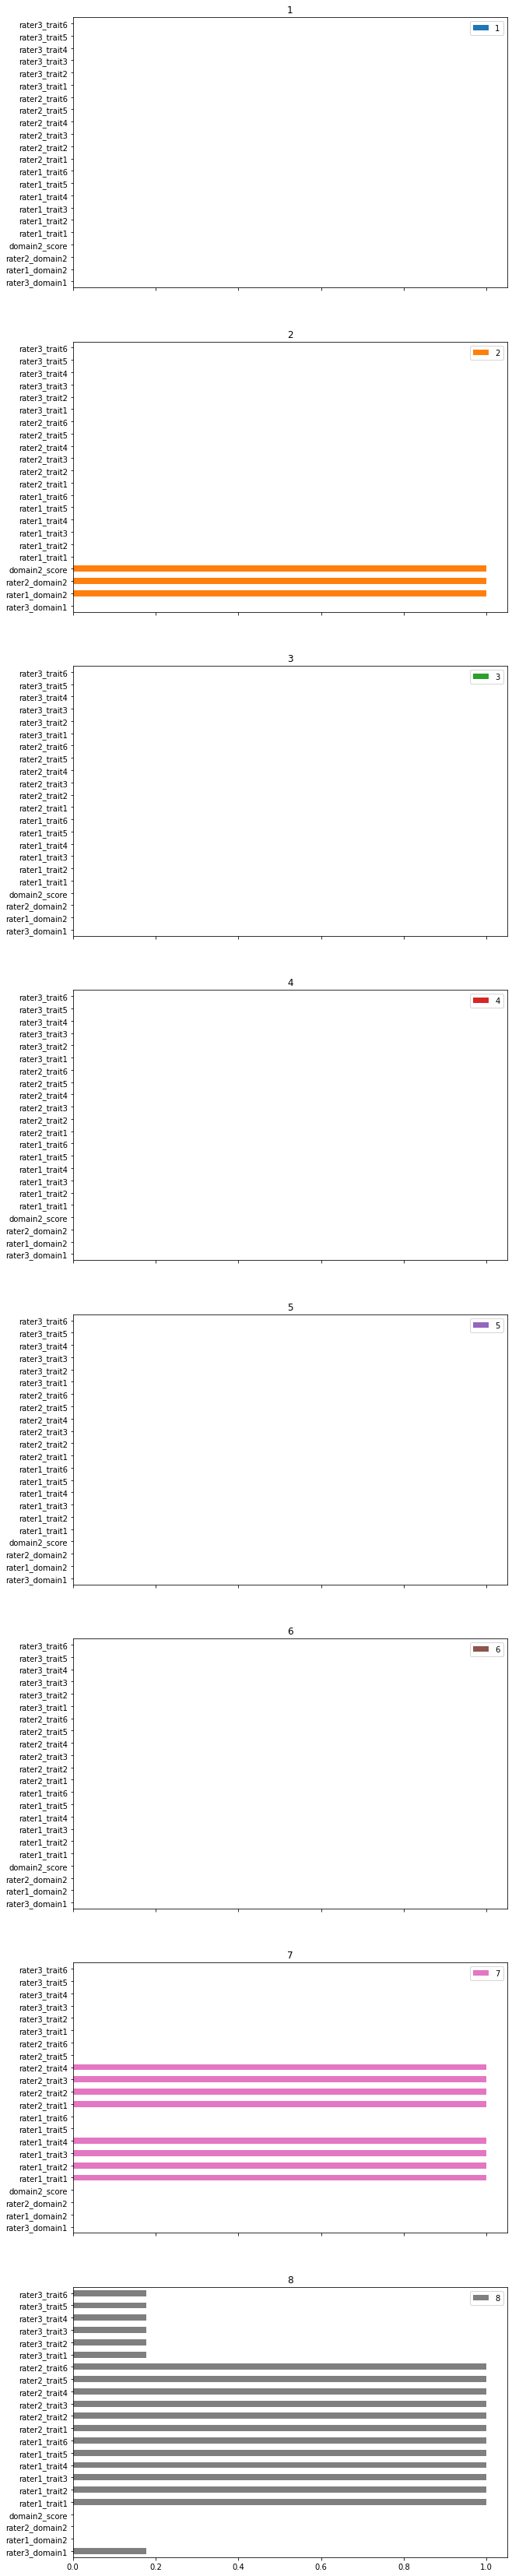

In [6]:
# Columns in which a majority of data is missing
missing_cols = essays.columns[essays.isna().mean() >= 0.5]

# We use `notna` rather than `isna` because most of these categories are only defined for a handful of sets
essays[missing_cols].notna().groupby(essays["essay_set"]).mean().T.plot.barh(figsize=(10, 60), subplots=True);

* Only essay set 2 contains `domain2_score`, `rater1_doman1`, and `rater2_domain2`.
* Only essays sets 7 and 8 contain `rater{1..2}_trait{1..4}`.
* Only essay set 8 contains `rater3_domain1`, `rater{1..2}_trait{5..6}`, and `rater3_trait{1..6}`.

## Domains & Traits

In [7]:
domain_cols = [
    "rater1_domain1",
    "rater1_domain2",
    "rater2_domain1",
    "rater2_domain2",
    "rater3_domain1",
]

trait_cols = [
    "rater1_trait1",
    "rater1_trait2",
    "rater1_trait3",
    "rater1_trait4",
    "rater1_trait5",
    "rater1_trait6",

    "rater2_trait1",
    "rater2_trait2",
    "rater2_trait3",
    "rater2_trait4",
    "rater2_trait5",
    "rater2_trait6",

    "rater3_trait1",
    "rater3_trait2",
    "rater3_trait3",
    "rater3_trait4",
    "rater3_trait5",
    "rater3_trait6",
]

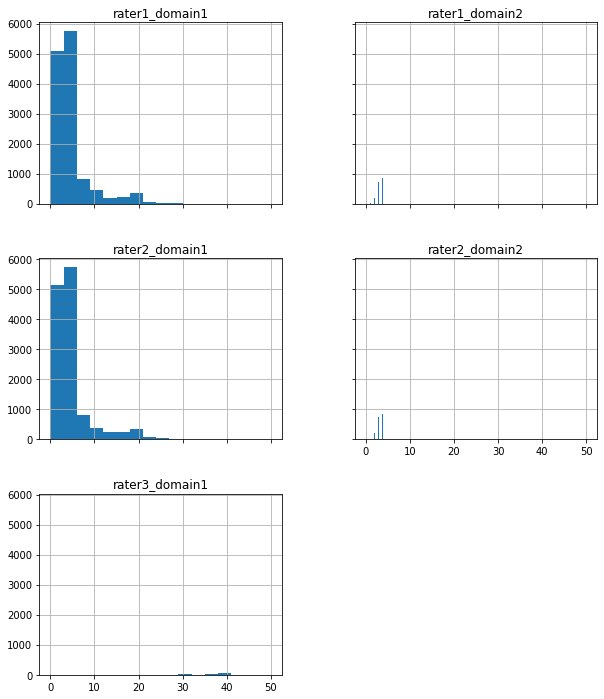

In [8]:
essays.hist(column=domain_cols, figsize=(10, 12), sharex=True, sharey=True);

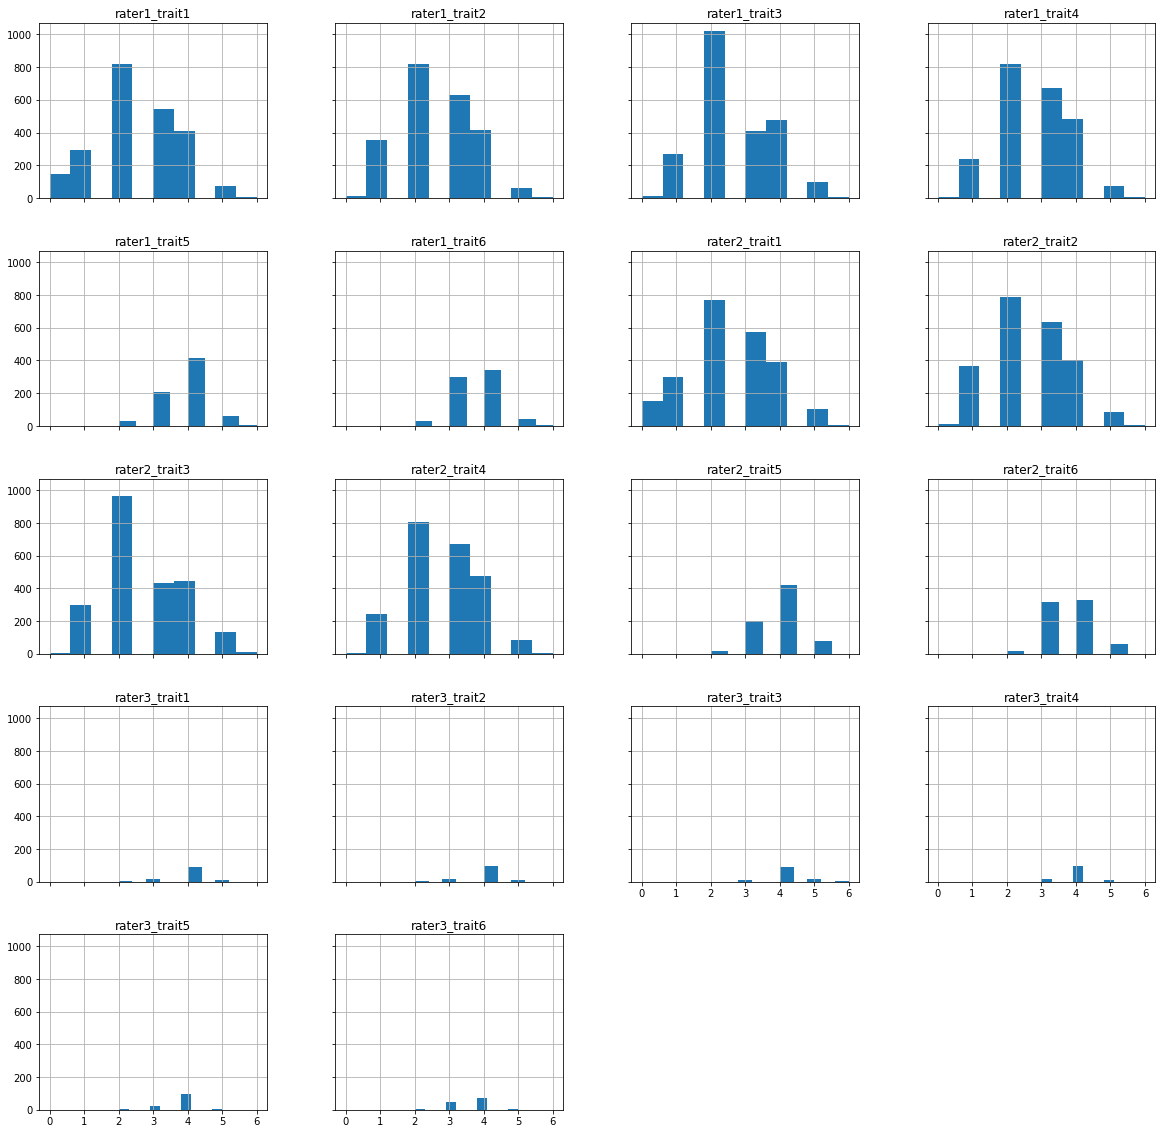

In [9]:
essays.hist(column=trait_cols, figsize=(20, 20), sharex=True, sharey=True);

## Score distribution

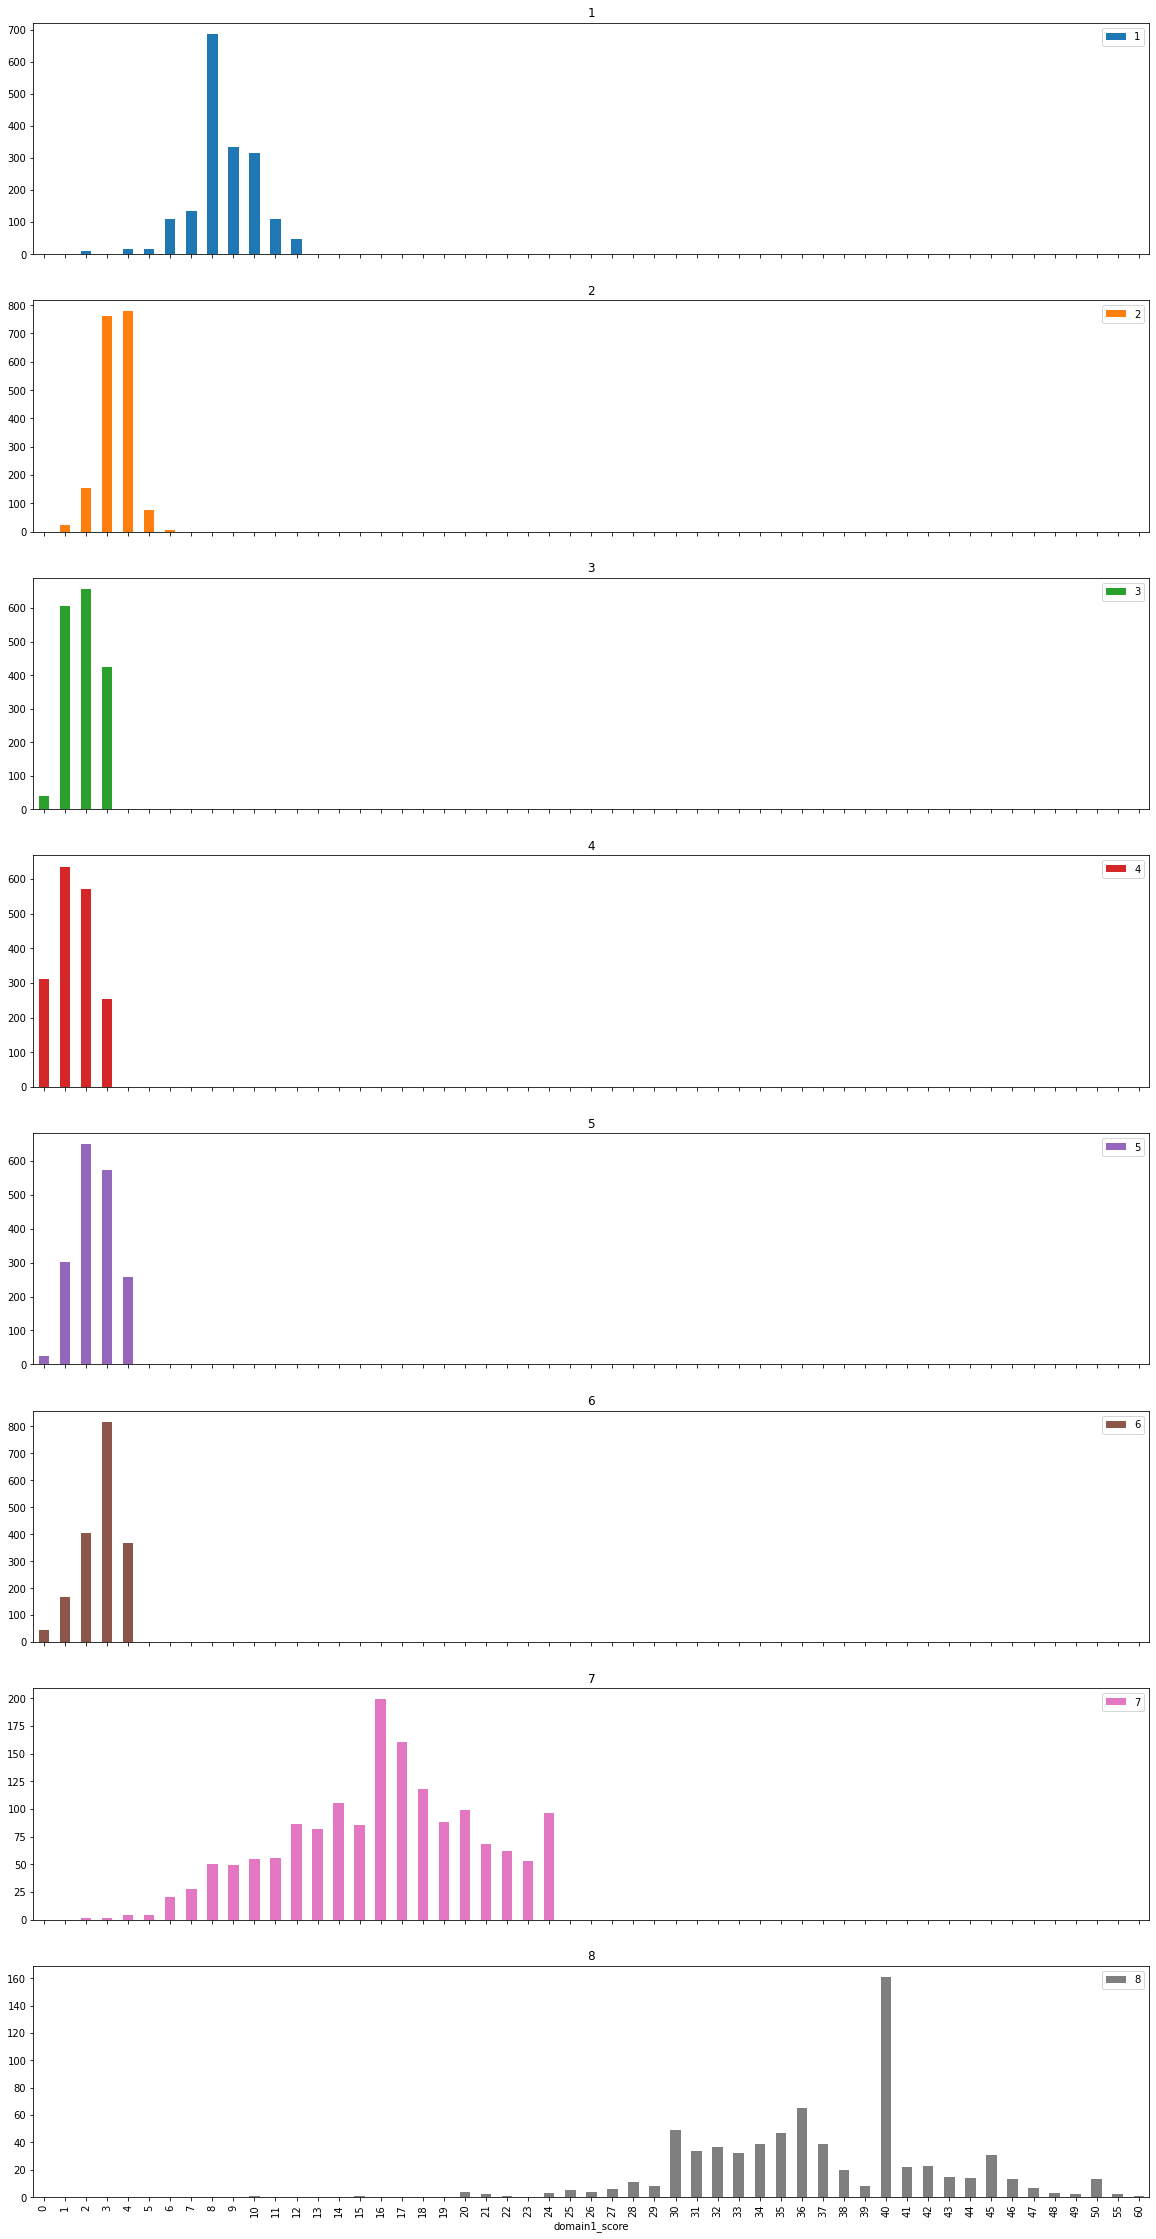

In [10]:
# Show distribution of scores by essay set
essays.groupby(["essay_set", "domain1_score"])["essay_id"].count().unstack().T.plot.bar(subplots=True, figsize=(20, 40));

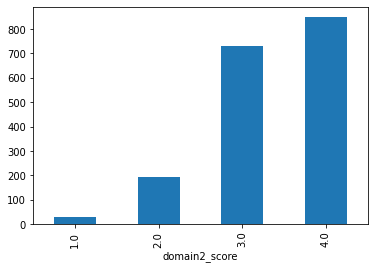

In [11]:
essays[essays["essay_set"] == 2].groupby("domain2_score")["essay_id"].count().plot.bar();

# Define metrics

In [12]:
def freq_score(doc):
    """Calculates an arbitrarily-defined "frequency metric"
    that tries to capture how many infrequent words are used
    in the text."""
    l = []
    score = 0
    known_words = 0
    for word in doc:
        lemma = word.lemma_
        try:
            score += (freqs.loc[lemma, "rank"])
            l.append((lemma, freqs.loc[lemma, "rank"]))
            known_words += 1
        except KeyError:
            pass
    return np.log(score/known_words)

def freq_graph(doc):
    """Calculates an arbitrarily-defined "frequency metric"
    that tries to capture how many infrequent words are used
    in the text."""
    lemmas = set([word.lemma_ for word in doc if word.lemma_ in freqs.index])
    plt.figure()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(freqs["rank"].min(), freqs["rank"].max())
    plt.scatter("rank", freq_col, data=freqs.loc[lemmas, :], color="red");
    plt.text(x=freqs.loc[lemmas, :]["rank"], y=freqs.loc[lemmas, :][freq_col], s=lemmas)
    
# Demonstrate "frequency metric" on some sample sentences
sents = [
    "I am he as you are he as you are me and we are all together.",
    "We shall fight on the beaches.",
    "The cat sat on the mat.",
    "The boy stood on the burning deck whence all but he had fled.",
    "In a hole in the ground, there lived a hobbit.",
    "'Twas brillig, and the slithy toves did gyre and gimble in the wabe."
]

# for sent in sents:
#     s = nlp(sent)
#     print(freq_score(s))
#     freq_graph(s)

In [13]:
def tf_idf(i, j):
    """Calculates tf-idf score for each word in the
    FIRST corpus passed."""
    tf = i / (i + j)
    
    i_count = (i != 0).astype(int)
    j_count = (j != 0).astype(int)
    idf = np.log((i_count + j_count) / i_count)
    
    return df * idf

The tf-idf is a widely-used metric for showing the distribution of a word type between corpora; however, it's a bit austere in assigning a value of 0 to any word type which occurs in both corpora. Here we prefer the log-odds with uninformative Dirichlet prior (Monroe et al. 2008), which weighs the odds ratio of the word's appearance in each distribution against the prior probability of its appearing in *either* distribution. This model has the downside that a word appearing in only one corpus has infinite (or negatively infinite) log odds—we deal with this by adding one to each observation, per Laplace's [Rule of Succession](https://en.wikipedia.org/wiki/Rule_of_succession).

In [14]:
def logodds_dirichlet(i, j, prior=None):
    """Calculate log-odds, uninformative Dirichlet prior
    (Monroe et al. 2008, sec. 3.3.4). The higher a word's
    value, the more "representative" it is of corpus i.
    A values of zero means no preference between corpora."""

    # Add one to each observation, per Laplace's Rule of
    # Succession, so we don't end up dividing by zero.
    i += 1
    j += 1
    
    if prior is None:
        prior = i + j
    
    # Compute word frequency totals
    n_i     = np.sum(i)
    n_j     = np.sum(j)
    n_prior = np.sum(prior) # α_0

    # Compute the prior log odds
    delta = np.log((i + prior) / (n_i + n_prior - i - prior)) - \
            np.log((j + prior) / (n_j + n_prior - j - prior))

    # Compute the standard deviation
    sigma = np.sqrt(1/(i + prior) + 1/(j + prior))

    # Convert to z-score
    return delta / sigma

# Compute metrics

In [15]:
def is_word(w):
    return (not w.is_space) and (not w.is_punct)


@show_progress
def parse_essays(i, essay):
    # Compute various metrics:
    doc = nlp(essay)

    # Token count
    essays.loc[i, "tokens"] = len(list(filter(is_word, doc)))

    # Type count (may be inflated by misspellings)
    essays.loc[i, "types"] = len(set([word.lemma_ for word in doc if not word.is_punct and not word.is_space]))
    
    # Mean sentence length
    essays.loc[i, "sent_len"] = np.mean([len(list(filter(is_word, s))) for s in doc.sents])
    
    # Mean word length
    essays.loc[i, "word_len"] = np.mean(list(map(len, filter(is_word, doc))))

    # Semicolons
    essays.loc[i, "semicolons"] = len([token for token in doc if token.text == ";"])

In [16]:
parse_essays(essays["essay"])

Done! Parsed 12976 items in 0:08.


# Compute scores

In [19]:
# If only one score exists, use that. Otherwise, take the mean of both scores.
essays["score"] = list(map(np.nanmean, zip(essays["domain1_score"], essays["domain2_score"])))

# Write out

In [20]:
# Columns in which no values are missing
complete_cols = essays.columns[essays.notna().all()]

# Sets with no additional columns
for i in [1,3,4,5,6]:
    essays[essays["essay_set"] == i][complete_cols]\
    .to_csv(f"../data_private/essays_cleaned_set_{i}.csv", index=False)

# Sets with additional columns
extra_cols = {
    2: ["domain2_score", "rater1_domain1", "rater2_domain2"],
    7: [f"rater{i}_trait{j}" for i in range(1,3) for j in range(1,5)],
    8: [f"rater{i}_trait{j}" for i in range(1,4) for j in range(1,7)]
}

for i in [2,7,8]:
    essays[essays["essay_set"] == i][[*complete_cols, *extra_cols[i]]]\
    .to_csv(f"../data_private/essays_cleaned_set_{i}.csv", index=False)

# References

Monroe, Burt L., Michael P. Colaresi, and Kevin M. Quinn. 2008. “Fightin’ Words: Lexical Feature Selection and Evaluation for Identifying the Content of Political Conflict.” *Political Analysis* 16 (4): 372–403. doi:[10.1093/pan/mpn018](https://doi.org/10.1093/pan/mpn018).